In [1]:
import matplotlib.pyplot as plt
from utils.operators import top_k_op, hosvd_compression_op
from utils.train import run_training
from utils.graphs import plot_training_results

compression_operators = {
    'Id': lambda x: x,
    'TopK': top_k_op(k=5),
    'HOSVD': hosvd_compression_op(),
}

num_epochs = 2

for name, op in compression_operators.items():
    run_training(
        compression_op_name=name, 
        compression_op=op, 
        num_epochs=num_epochs,
        # device='misha'
    )

Files already downloaded and verified
Starting epoch 16 with Id
Starting epoch 17 with Id
Files already downloaded and verified
Starting epoch 16 with TopK
Starting epoch 17 with TopK
Files already downloaded and verified
Starting epoch 16 with HOSVD
Starting epoch 17 with HOSVD


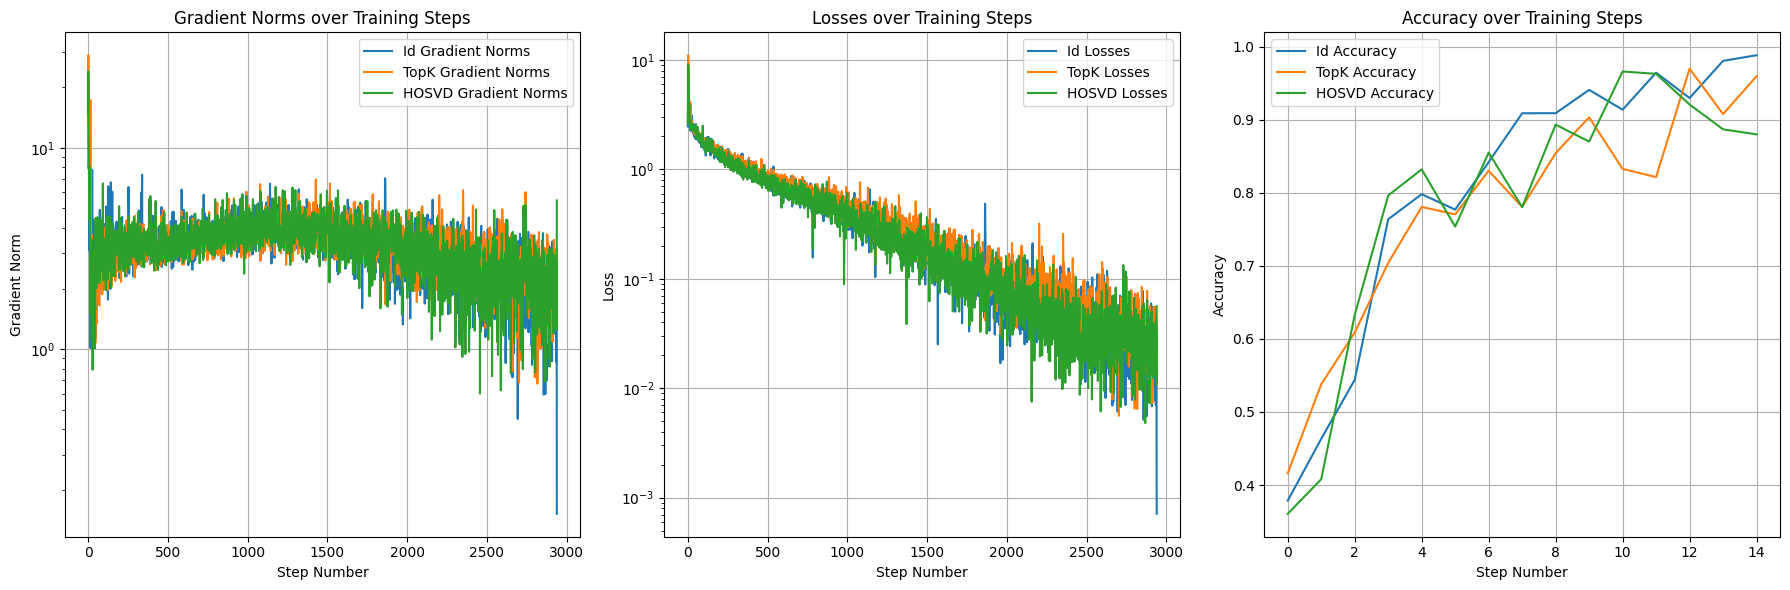

In [6]:
plot_training_results(compression_operators)